In [ ]:
# std lib
from getpass import getpass
import random

# 3rd party 
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from sparcl.client import SparclClient

import numpy as np
import healpy as hp
import sys

<a class="anchor" id="async"></a>
# ALLWISE

In [2]:
query = """
SELECT 
S.w1mpro as w1, S.w2mpro as w2, S.source_id as id, S.ra as ra, S.dec as dec, S.ring256 as ring256, S.w1snr as w1snr, S.w2snr as w2snr, S.cc_flags as cc_flags, S.glat as lat, S.glon as lon
FROM allwise.source as S
WHERE ((S.w1mpro - S.w2mpro) > 0.65*EXP((0.153*POWER(ABS(S.w2mpro-13.86),2))) AND S.w2mpro > 13.86) 
OR ((S.w1mpro - S.w2mpro) > 0.65 AND S.w2mpro < 13.86) 
"""

In [ ]:
final_table = qc.query(sql=query, timeout = 100000, out='mydb://allwise_firstpass', drop=True)
print(final_table)

In [ ]:
#ALLWISE
new_query = """
SELECT *
FROM mydb://allwise_firstpass
WHERE w1 > 8 AND w2 > 7 AND w1snr>3 AND w2snr>5 AND CAST(cc_flags as char)='0'
"""

In [ ]:
final_table = qc.query(sql=new_query, timeout = 100000, out='mydb://allwise_errorcuts', drop=True)
print(final_table)

In [ ]:
query = """
SELECT *
FROM mydb://allwise_errorcuts
WHERE NOT q3c_radial_query(lon, lat, 0, 0, 30) AND (lat > 10 or lat < -10)
"""
final_table = qc.query(sql=query, timeout = 100000, out='mydb://allwise_center_errorcut', drop=True)
print(final_table)
print(qc.mydb_list())

In [ ]:
#ALLWISE
test_table = qc.query('select ra from mydb://allwise_center_errorcut', fmt = 'pandas')
print(test_table)
test_table = qc.query('select COUNT(ra), ring256 from mydb://allwise_center_errorcut group by ring256', fmt = 'pandas')
print(test_table)

In [ ]:
test_table = test_table.sort_values(by=['ring256'])
ring256 = np.array(test_table.loc[:,'ring256'])
counts = np.array(test_table.loc[:,'count'])
empty_counts = np.zeros(hp.nside2npix(256))
for i in range(len(counts)):
    empty_counts[ring256[i]] = counts[i]


In [ ]:
wise_data = qc.query('select * from mydb://wise_table', fmt = 'pandas')
print(wise_data)

In [ ]:
decl = wise_data.loc[:,'dec']
RA = wise_data.loc[:,'ra']
pixels = np.array(hp.pixelfunc.ang2pix(256,np.radians(-decl+90.),np.radians(360.+RA)))
pixels.sort()
frequency = {}
for i in range (0, 4543530):
    frequency[pixels[i]] = frequency.get(pixels[i], 0) + 1
keys = list(frequency.keys())
vals = list(frequency.values())

In [ ]:
empty_wise_counts = np.zeros(hp.nside2npix(256))
for i in range(len(vals)):
    empty_wise_counts[keys[i]] = vals[i]

In [ ]:
hp.mollview(empty_counts, title="AGN Count", norm='hist')
hp.mollview(empty_wise_counts, title="AGN Count", norm='hist')

In [ ]:
hist_table = qc.query('select w1, w2 from mydb://allwise_center_errorcut', fmt = 'pandas')

In [ ]:
plt.hist(hist_table.loc[:,'w1'], bins = 20,label = "My Query", color = 'b', alpha = 0.5)
plt.hist(wise_data.loc[:,'w1mpro'], bins = 20,label = "Assef et al. 2018", color= 'r',alpha = 0.5)
plt.title("W1 Magnitude")
plt.legend()
plt.show()
plt.hist(hist_table.loc[:,'w2'], bins = 20,label = "My Query", alpha = 0.5, color= 'b')
plt.hist(wise_data.loc[:,'w2mpro'], bins = 20,label = "Assef et al. 2018", alpha = 0.5, color= 'r')
plt.title("W2 Magnitude")
plt.legend()
plt.show()

In [ ]:
w21_my = hist_table.loc[:,'w2']-hist_table.loc[:,'w1']
w21_assef = wise_data.loc[:,'w2mpro']-wise_data.loc[:,'w1mpro']
w2 = hist_table.loc[:,'w2']
w2_assef =  wise_data.loc[:,'w2mpro']

In [ ]:
plt.hist2d(w2,w21_my, bins = 40,norm=matplotlib.colors.LogNorm())
plt.title("W2-W1 CMD from my query")
plt.xlabel('W2 magnitude')
plt.ylabel('W2-W1')
plt.show()
plt.hist2d(w2_assef,w21_assef,bins = 40,norm=matplotlib.colors.LogNorm())
plt.title("W2-W1 CMD from Assef et. al. data")
plt.ylabel('W2-W1')
plt.xlabel('W2 magnitude')
plt.show()

<a class="anchor" id="async"></a>
# unWISE

In [24]:
#UNWISE
squery = """
SELECT 
S.mag_w1_vg as w1, S.mag_w2_vg as w2, S.unwise_objid as id, S.ra as ra, S.dec as dec, S.ring256 as ring256, S.glat as lat, S.glon as lon
FROM unwise_dr1.object as S
WHERE S.mag_w2_vg > 7.032 AND S.mag_w1_vg > 8.004 AND (S.glat > 10 OR S.glat < -10)
"""

In [ ]:
new_table = qc.query(sql=squery, timeout = 1000000, out='mydb://unwise_mags', async_=True, poll=60, verbose = 1, wait=True, drop=True)
print(new_table)

In [41]:
print(qc.mydb_list())

allwise_center_errorcut
allwise_errorcuts
allwise_firstpass
tbl_stat
unwise
unwise_center_errorcut
unwise_firstpass
unwise_mags
wise_table



In [42]:
query = """
SELECT *
FROM mydb://unwise_mags
WHERE ((w1-w2-0.036) > 0.65*EXP((0.153*POWER(ABS(w2-13.892),2))) AND w2 > 13.892) OR ((w1-w2-0.036) > 0.65 AND w2 < 13.892) 
"""

In [43]:
#UNWISE
final_table = qc.query(sql=query, timeout = 1000000, out='mydb://unwise_firstpass', drop=True)
print(final_table)

OK


In [44]:
#UNWISE
query = """
SELECT *
FROM mydb://unwise_firstpass
WHERE NOT q3c_radial_query(lon, lat, 0, 0, 30)
"""
final_table = qc.query(sql=query, timeout = 100000, out='mydb://unwise_center_errorcut', drop=True)
print(final_table)

OK


In [46]:
#UNWISE
test_table = qc.query('select w2 from mydb://unwise_center_errorcut', fmt = 'pandas')
print(test_table)
#UNWISE
test_table = qc.query('select COUNT(ra), ring256 from mydb://unwise_center_errorcut group by ring256', fmt = 'pandas')
print(test_table)

             w2
0      7.052444
1      7.251256
2      7.285864
3      7.079338
4      7.259089
...         ...
7625  11.218826
7626  11.200016
7627  11.137479
7628  10.923736
7629  11.010469

[7630 rows x 1 columns]
      count  ring256
0         1   554098
1         1    53949
2         3   761669
3         1   270017
4         1   771556
...     ...      ...
5226      1   185773
5227      1   749278
5228      2   767120
5229      1   359580
5230      1     1715

[5231 rows x 2 columns]


In [47]:
test_table = test_table.sort_values(by=['ring256'])
ring256 = np.array(test_table.loc[:,'ring256'])
counts = np.array(test_table.loc[:,'count'])
empty_counts = np.zeros(hp.nside2npix(256))
for i in range(len(counts)):
    empty_counts[ring256[i]] = counts[i]


In [ ]:
wise_data = qc.query('select * from mydb://wise_table', fmt = 'pandas')
print(wise_data)

In [ ]:
decl = wise_data.loc[:,'dec']
RA = wise_data.loc[:,'ra']
pixels = np.array(hp.pixelfunc.ang2pix(256,np.radians(-decl+90.),np.radians(360.+RA)))
pixels.sort()
frequency = {}
for i in range (0, 4543530):
    frequency[pixels[i]] = frequency.get(pixels[i], 0) + 1
keys = list(frequency.keys())
vals = list(frequency.values())

In [ ]:
empty_wise_counts = np.zeros(hp.nside2npix(256))
for i in range(len(vals)):
    empty_wise_counts[keys[i]] = vals[i]

In [ ]:
hp.mollview(empty_counts, title="AGN Count", norm='hist')
hp.mollview(empty_wise_counts, title="AGN Count", norm='hist')

In [11]:
hist_table = qc.query('select w1, w2 from mydb://allwise_center_errorcut', fmt = 'pandas')

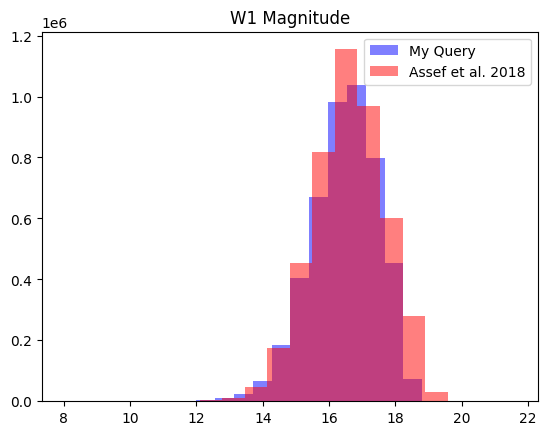

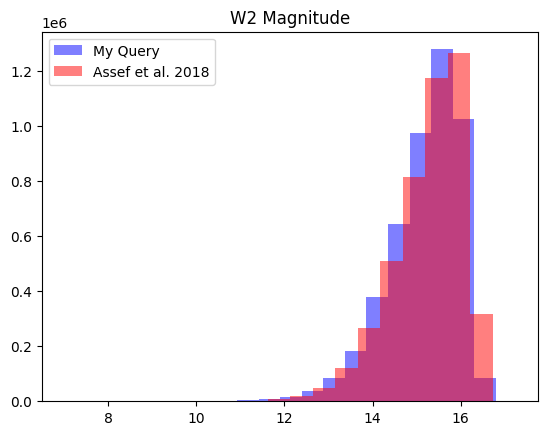

In [12]:
plt.hist(hist_table.loc[:,'w1'], bins = 20,label = "My Query", color = 'b', alpha = 0.5)
plt.hist(wise_data.loc[:,'w1mpro'], bins = 20,label = "Assef et al. 2018", color= 'r',alpha = 0.5)
plt.title("W1 Magnitude")
plt.legend()
plt.show()
plt.hist(hist_table.loc[:,'w2'], bins = 20,label = "My Query", alpha = 0.5, color= 'b')
plt.hist(wise_data.loc[:,'w2mpro'], bins = 20,label = "Assef et al. 2018", alpha = 0.5, color= 'r')
plt.title("W2 Magnitude")
plt.legend()
plt.show()

In [21]:
w21_my = hist_table.loc[:,'w2']-hist_table.loc[:,'w1']
w21_assef = wise_data.loc[:,'w2mpro']-wise_data.loc[:,'w1mpro']
w2 = hist_table.loc[:,'w2']
w2_assef =  wise_data.loc[:,'w2mpro']

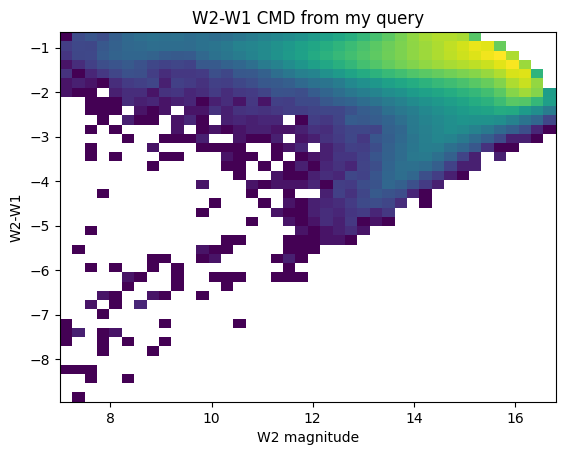

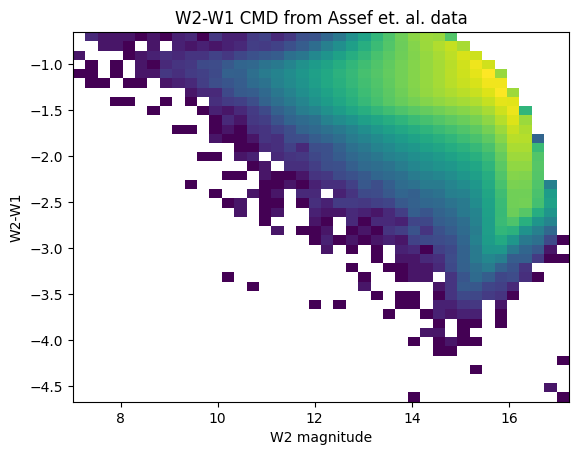

In [43]:
plt.hist2d(w2,w21_my, bins = 40,norm=matplotlib.colors.LogNorm())
plt.title("W2-W1 CMD from my query")
plt.xlabel('W2 magnitude')
plt.ylabel('W2-W1')
plt.show()
plt.hist2d(w2_assef,w21_assef,bins = 40,norm=matplotlib.colors.LogNorm())
plt.title("W2-W1 CMD from Assef et. al. data")
plt.ylabel('W2-W1')
plt.xlabel('W2 magnitude')
plt.show()